In [27]:
import sys
sys.path.append("..")

import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from pprint import pprint 

from src.seeds import Seeds
from src.gensim_word2vec_procrustes_align import smart_procrustes_align_gensim

### Find differences of meaning in time

The idea here is to consider the vectors coming from the different epochs and to find a difference in meaning in time. We can clearly see that some words change meaning by printing the top similar ones. For instance, the word drug is related to products in general, probably linked to the meaning of drugstore, while from 1920 on the word have a different context, related to narcotics.

To quantify this semantic shift we take the approach introduced here (https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8), that aligns the gensim models making them comparable.

We can see that the cosine similarity is increased when aligning two models, the idea now is to align models in a sequential fashion, so: 

align(2000, 1980), align(1980, 1960)... 

The models are aligned pairwise and the shift is detected comparing cosine similarities between adjacent years.

In [15]:
def print_similar(word, models, n=5):
    print(word)
    for y, m in models.items():
        try:
            print(f"\t{y}: {[e[0] for e in m.wv.most_similar(word, topn=n)]}")
        except:
            pass
        
def cos_sim(a, b):
    dot_product = np.dot(a, b) # x.y
    norm_a = np.linalg.norm(a) #|x|
    norm_b = np.linalg.norm(b) #|y|
    return dot_product / (norm_a * norm_b)

def get_similarity(m1, m2, word):
    try:
        return cos_sim(m1.wv[word], m2.wv[word])
    except:
        return -1
    
def get_similarity_sequence(models, base, years, word):
    return [get_similarity(models[base], models[e], word) for e in years]

def orderd_by_semantic_shift(words, models, years, base="2010", interval=-1):
    res = []
    for word in words:
        s = get_similarity_sequence(models, base, years, word)[:interval]
        s = [e for e in s if e>0]
        if s:
            index = np.argmin(s)
            res.append((word, years[index], s[index]))
        else:
            print(word, "not in models")
        
    res.sort(key=lambda x : x[2])
    return res

### Aligning the models

### Detecting semantic shifts

In [3]:
directory = "../data/models/one_year_time_vectors"

def get_name(s):
    s = s.split("/")[-1]
    l = s.split("_")
    return f"{l[0]}_{l[-2]}" if len(l)>2 else l[0]

models = { get_name(model_name) : Word2Vec.load(model_name) 
          for model_name in [f"{directory}/{el}" for el in sorted(os.listdir(directory)) if "npy" not in el]}

In [4]:
years = sorted(list(models.keys()), reverse=True)
couple_list = list(zip(years, years[1:]))
print(couple_list[:3], "...")

[('2010', '2009'), ('2009', '2008'), ('2008', '2007')] ...


In [5]:
for base, other in couple_list:
    smart_procrustes_align_gensim(models[base], models[other])

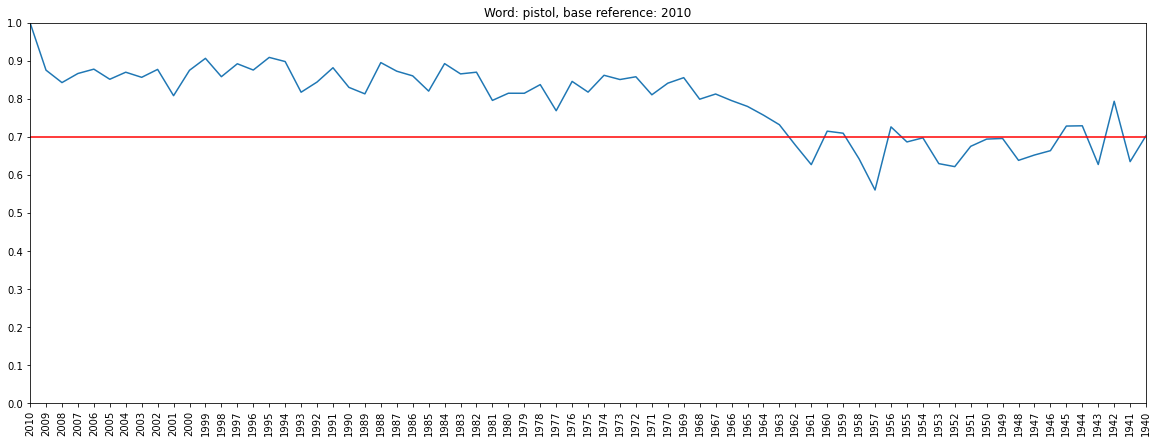

pistol
	1940: ['display', 'knife', 'gun', 'fight', 'wear', 'cold', 'push', 'companion', 'hurt', 'shoot']
	1941: ['shoe', 'cold', 'twice', 'lady', 'pocket', 'frequent', 'extremely', 'sleep', 'inside', 'drop']
	1942: ['lock', 'knife', 'wound', 'tire', 'gun', 'bedroom', 'knock', 'push', 'engine', 'gate']
	1943: ['heat', 'size', 'neck', 'interval', 'ear', 'combination', 'assist', 'out', 'hole', 'upper']
	1944: ['tear', 'platform', 'watch', 'catch', 'wound', 'cab', 'companion', 'drink', 'push', 'dark']
	1945: ['knock', 'bone', 'push', 'suddenly', 'drink', 'outer', 'stair', 'lock', 'shoot', 'key']
	1946: ['wait', 'arrange', 'inside', 'finish', 'nearby', 'lock', 'pocket', 'movement', 'down', 'gate']
	1947: ['watch', 'sleep', 'stair', 'sure', 'bedroom', 'pocket', 'knife', 'defective', 'habit', 'clothe']
	1948: ['blood', 'weapon', 'pressure', 'inside', 'sight', 'plate', 'heart', 'mechanical', 'combine', 'loose']
	1949: ['boy', 'knock', 'attendant', 'summer', 'tractor', 'ice', 'sunday', 'attend'

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(20,7))

word = "pistol"
base = "2010"
x = [e for e in get_similarity_sequence(models=models, base=base, years=years, word=word) if e>0]
axs.plot(x)
plt.title(f"Word: {word}, base reference: {base}")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xticks(ticks=range(len(x)), labels=years[:len(x)], rotation=90)
plt.yticks(ticks=[i/10 for i in range(11)])
plt.axhline(y=0.7, color='r', linestyle='-')
plt.show()
# print_shift(find_semantic_shift(models, couple_list, word))
print_similar(word, models, 10)

In [32]:
a, b, c = Seeds().get_starting_seeds()

pprint(orderd_by_semantic_shift(a, models, years, base="2010", interval=10))

pprint(orderd_by_semantic_shift(b, models, years, base="2010", interval=10))

pprint(orderd_by_semantic_shift(c, models, years, base="2010", interval=10))

drugs not in models
lsd not in models
fentanyl not in models
ecstasy not in models
ketamine not in models
[('methamphetamine', '2002', 0.65811986),
 ('drug', '2006', 0.74600416),
 ('blunt', '2005', 0.759442),
 ('heroin', '2001', 0.7821121),
 ('marijuana', '2009', 0.8231671),
 ('cannabis', '2004', 0.8334723),
 ('cocaine', '2002', 0.8695918),
 ('overdose', '2010', 1.0)]
carbine not in models
musket not in models
derringer not in models
[('sword', '2005', 0.40951946),
 ('shotgun', '2008', 0.6433892),
 ('rifle', '2001', 0.7026196),
 ('firearm', '2001', 0.7267407),
 ('handgun', '2007', 0.734864),
 ('assault', '2004', 0.7693078),
 ('pistol', '2001', 0.8083847),
 ('gun', '2001', 0.8148943),
 ('knife', '2006', 0.82185155),
 ('weapon', '2007', 0.83537453),
 ('revolver', '2006', 0.8366753)]
cyber not in models
mafia not in models
cybercrime not in models
[('recidivism', '2008', 0.5538944),
 ('rape', '2004', 0.61033756),
 ('killer', '2009', 0.6970568),
 ('gang', '2006', 0.69975),
 ('serial', '200